In [2]:
d <- read.table('orange_small_train.data', header=TRUE, 
                sep='\t', na.strings=c('NA',''))

### Step 1: Split the data into training, calibration and test

In [3]:
churn <- read.table('orange_small_train_churn.labels.txt',
                   header=FALSE, sep='\t')
d$churn <- churn$V1

appetency <- read.table('orange_small_train_appetency.labels.txt',
                       header=F, sep='\t')
d$appetency <- appetency$V1

upselling <- read.table('orange_small_train_upselling.labels.txt',
                       header=F, sep='\t')
d$upselling <- upselling$V1

In [4]:
set.seed(729375)

#generate random variables with amount equal to the number of rows in d
d$rgroup <- runif(dim(d)[[1]])

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

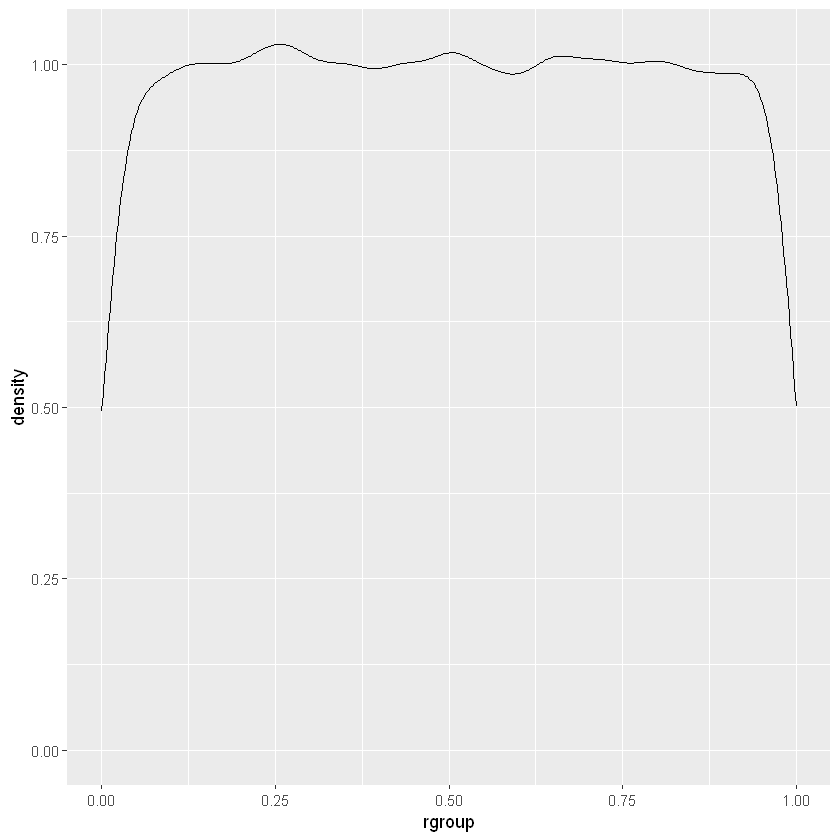

In [5]:
library(ggplot2)

ggplot(d, aes(x=rgroup)) + geom_density()

In [6]:
dTrainAll <- subset(d, rgroup <= 0.9)
dTest <- subset(d, rgroup>0.9)

outcomes = c('churn', 'appetency', 'upselling')
vars <- setdiff(colnames(dTrainAll),
               c(outcomes, 'rgroup'))
catVars <- vars[sapply(dTrainAll[,vars],class) %in%
               c('factor','character')]
numericVars <- vars[sapply(dTrainAll[,vars],class) %in%
                   c('numeric','integer')]

In [7]:
outcome <- 'churn'
pos <- '1'

#split the training data  into training and	calibration	subsets
useForCal <- rbinom(n=dim(dTrainAll)[[1]], size=1, prob=0.1) > 0
dCal <- subset(dTrainAll, useForCal) # calibration data
dTrain <- subset(dTrainAll, !useForCal) #training

### Step 2: Building a single-variable model

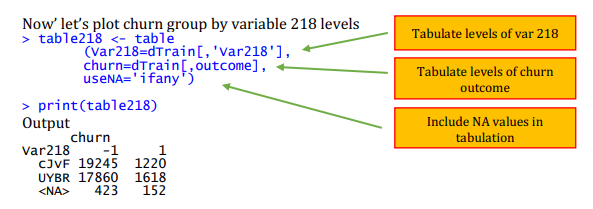

In [8]:
table218 <- table(Var218=dTrain[,'Var218'],
                 churn=dTrain[,outcome],
                 useNA='ifany')

print(table218)

      churn
Var218    -1     1
  cJvF 19245  1220
  UYBR 17860  1618
  <NA>   423   152


In [9]:
print(table218[,2]/(table218[,1]+table218[,2]))

      cJvF       UYBR       <NA> 
0.05961398 0.08306808 0.26434783 


In [12]:
mkPredC <- function(outCol, varCol, appCol){
    pPos <- sum(outCol==pos)/length(outCol) #calc avg of outcol
    naTab <- table(as.factor(outCol[is.na(varCol)]))
    pPosWna <- (naTab/sum(naTab))[pos]
    vTab <- table(as.factor(outCol), varCol)
    pPosWv <- (vTab[pos,]+1.0e-3*pPos)/(colSums(vTab)+1.0e-3)
    pred <- pPosWv[appCol]
    pred[is.na(appCol)] <- pPosWna
    pred[is.na(pred)] <- pPos
    pred
}

In [13]:
# apply single-categorical variable models to all datasets- dTrain, dCal, and dTest
for (v in catVars){
    pi <- paste('pred', v, sep='')
    dTrain[,pi] <- mkPredC(dTrain[,outcome], dTrain[,v], dTrain[,v])
    dCal[,pi] <- mkPredC(dTrain[,outcome], dTrain[,v], dCal[,v])
    dTest[,pi] <- mkPredC(dTrain[,outcome], dTrain[,v], dTest[,v])
}

In [16]:
# scoring categorical variables by AUC

library('ROCR')
library('gplots')

Warning message:
"package 'ROCR' was built under R version 3.6.3"Warning message:
"package 'gplots' was built under R version 3.6.3"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



#### scoring categorical variables by using AUC

In [24]:
calcAUC <- function(predcol, outcol){
    perf <- performance(prediction(predcol, outcol==pos), 'auc')
    as.numeric(perf@y.values)
}

In [26]:
for(v in catVars){
    pi <- paste('pred', v, sep='')
    aucTrain <- calcAUC(dTrain[,pi], dTrain[,outcome])
    if(aucTrain>=0.8){
        aucCal <- calcAUC(dCal[,pi], dCal[,outcome])
        print(sprintf("%s, trainAUC: %4.3f calibrationAUC: %4.3f",
                     pi, aucTrain, aucCal))
    }
}

[1] "predVar200, trainAUC: 0.830 calibrationAUC: 0.565"
[1] "predVar202, trainAUC: 0.827 calibrationAUC: 0.525"
[1] "predVar214, trainAUC: 0.830 calibrationAUC: 0.565"
[1] "predVar217, trainAUC: 0.897 calibrationAUC: 0.553"


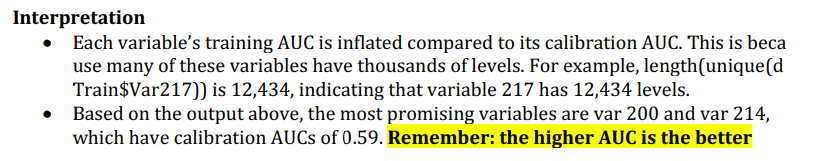

#### scoring numerical variables by AUC

In [27]:
mkPredN <- function(outCol, varCol, appCol) {
    cuts <- unique(as.numeric(quantile(varCol, probs=seq(0, 1, 0.1), na.rm=T)))
    varC <- cut(varCol, cuts)
    appC <- cut(appCol, cuts)
    mkPredC(outCol, varC, appC)
}

In [28]:
for(v in numericVars){
    pi <- paste('pred', v, sep='')
    dTrain[,pi] <- mkPredN(dTrain[,outcome], dTrain[,v], dTrain[,v])
    dTest[,pi] <- mkPredN(dTrain[,outcome], dTrain[,v], dTest[,v])
    dCal[,pi] <- mkPredN(dTrain[,outcome], dTrain[,v], dCal[,v])
    aucTrain <- calcAUC(dTrain[,pi], dTrain[,outcome])
    if(aucTrain >= 0.55){
        aucCal <- calcAUC(dCal[,pi], dCal[,outcome])
        print(sprintf("%s, trainAUC: %4.3f calibrationAUC: %4.3f",
                     pi, aucTrain, aucCal))
    }
}

[1] "predVar6, trainAUC: 0.557 calibrationAUC: 0.554"
[1] "predVar7, trainAUC: 0.555 calibrationAUC: 0.565"
[1] "predVar13, trainAUC: 0.568 calibrationAUC: 0.553"
[1] "predVar73, trainAUC: 0.608 calibrationAUC: 0.616"
[1] "predVar74, trainAUC: 0.574 calibrationAUC: 0.566"
[1] "predVar81, trainAUC: 0.558 calibrationAUC: 0.542"
[1] "predVar113, trainAUC: 0.557 calibrationAUC: 0.567"
[1] "predVar126, trainAUC: 0.635 calibrationAUC: 0.629"
[1] "predVar140, trainAUC: 0.561 calibrationAUC: 0.560"
[1] "predVar189, trainAUC: 0.574 calibrationAUC: 0.599"


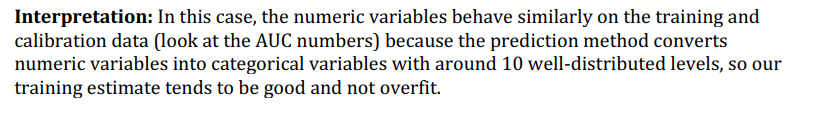

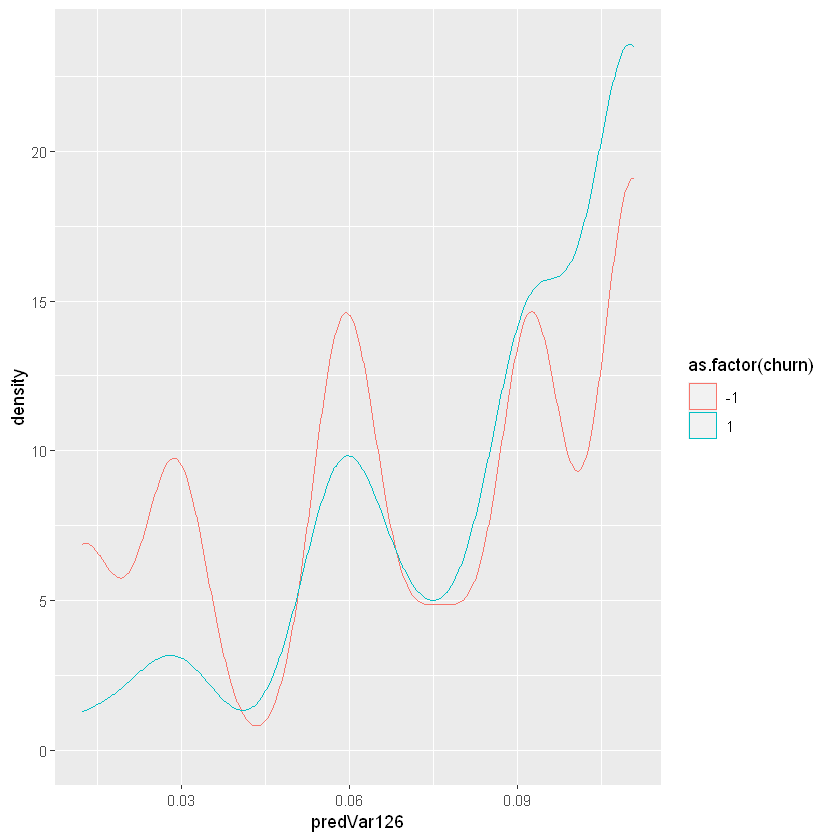

In [29]:
library(ggplot2)
ggplot(data=dCal, aes(x=predVar126, color=as.factor(churn))) +
    geom_density()

---
### Exercise

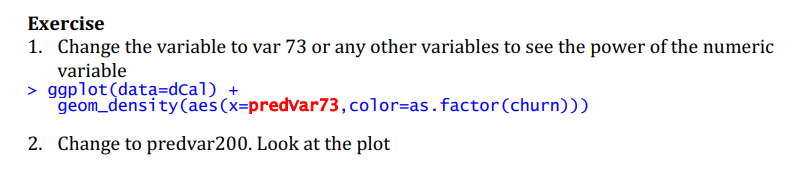

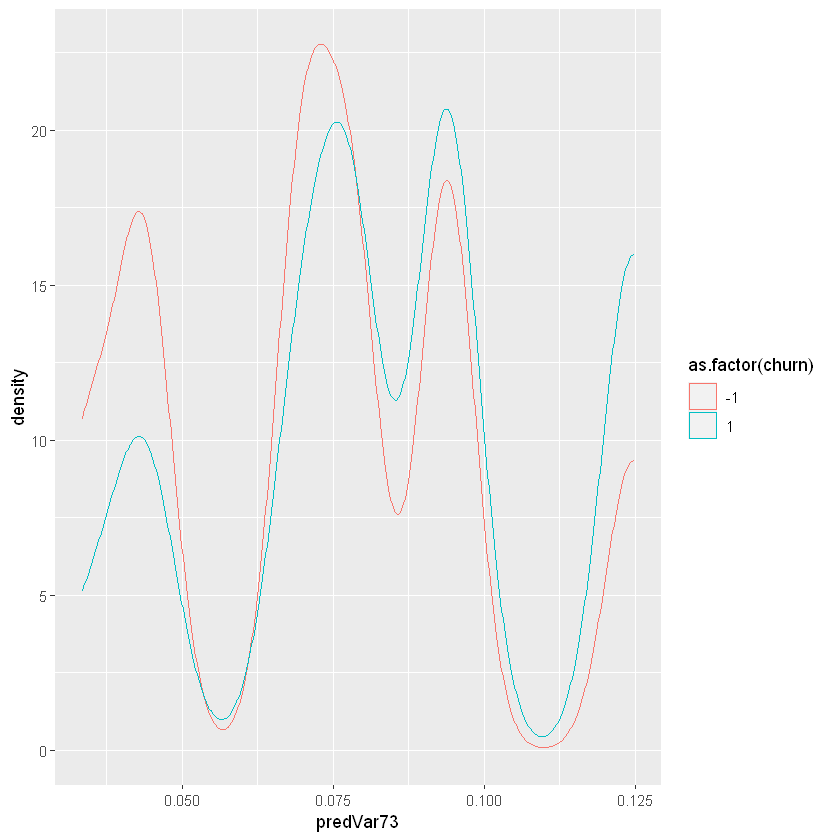

In [31]:
ggplot(data=dCal, aes(x=predVar73, color=as.factor(churn))) +
    geom_density()

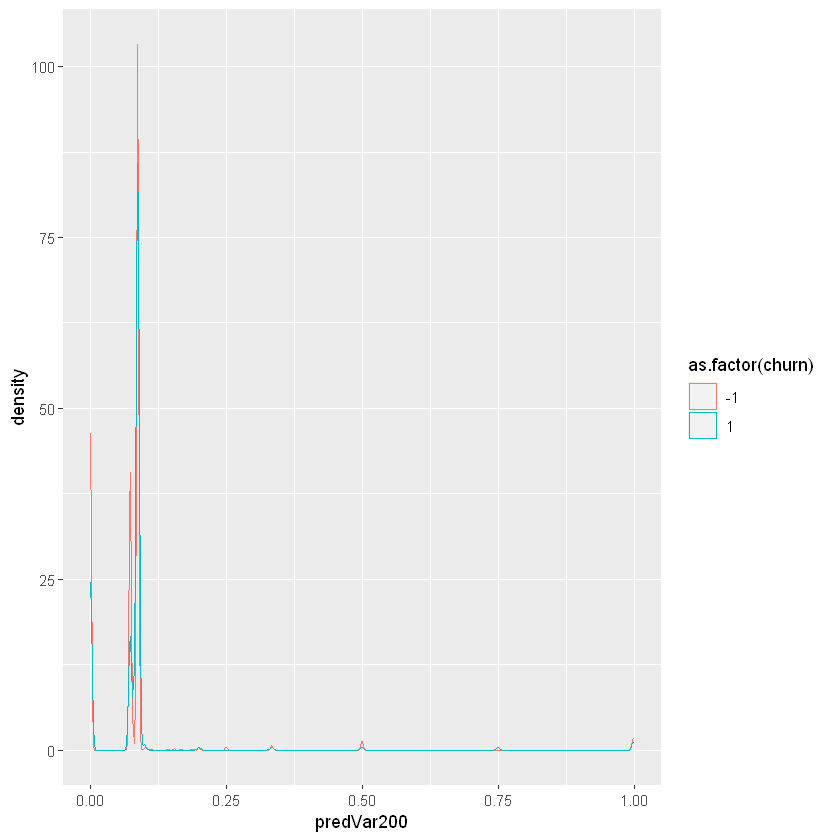

In [33]:
ggplot(data=dCal, aes(x=predVar200, color=as.factor(churn))) +
    geom_density()

Warning message:
"Removed 127 rows containing non-finite values (stat_density)."

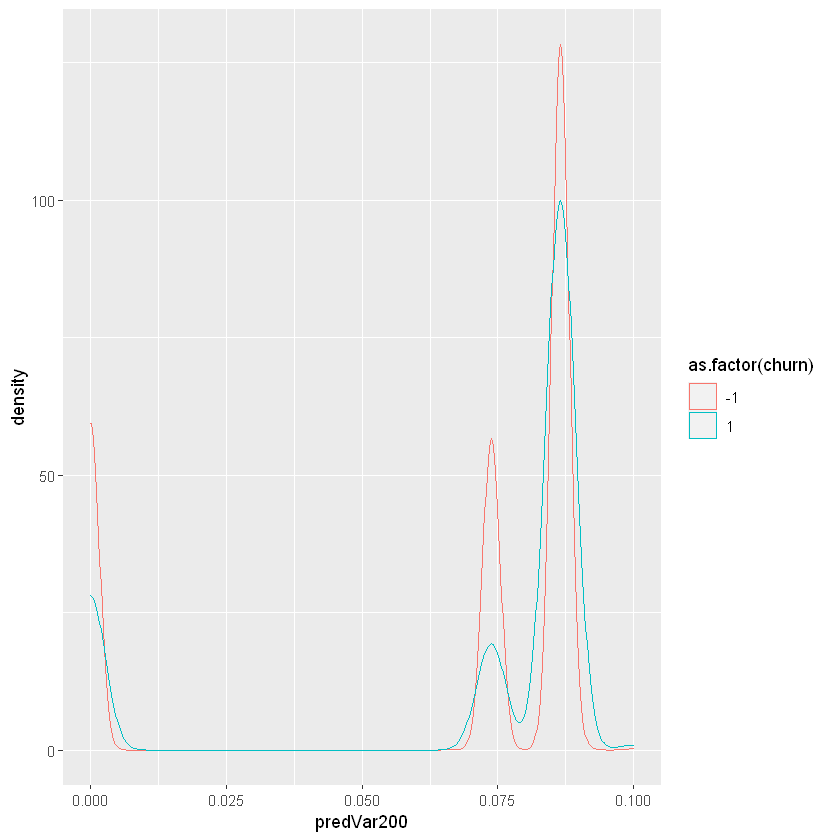

In [36]:
ggplot(data=dCal, aes(x=predVar200, color=as.factor(churn))) +
    geom_density() + xlim(0, 0.1)

### Step 3: Cross-validation on the model

In [43]:
var <- 'Var217'

aucs <- rep(0, 100)
for(rep in 1:length(aucs)){
    useForCalRep <- rbinom(n=dim(dTrainAll)[[1]], size=1, prob=0.1) > 0
    predRep <- mkPredC(dTrainAll[!useForCalRep, outcome],
                      dTrainAll[!useForCalRep, var],
                      dTrainAll[useForCalRep, var])
    aucs[rep] <- calcAUC(predRep, dTrainAll[useForCalRep, outcome])
}

In [44]:
mean(aucs)

[1] 0.5569457

In [45]:
sd(aucs)

[1] 0.01590692

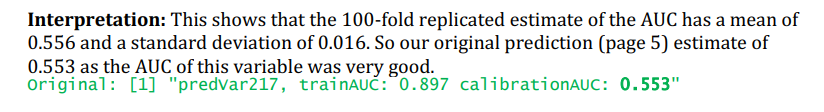

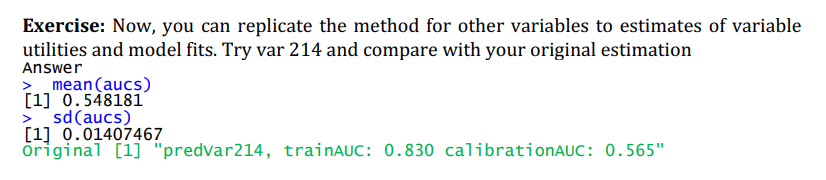

In [46]:
var <- 'Var214'

aucs <- rep(0, 100)
for(rep in 1:length(aucs)){
    useForCalRep <- rbinom(n=dim(dTrainAll)[[1]], size=1, prob=0.1) > 0
    predRep <- mkPredC(dTrainAll[!useForCalRep, outcome],
                      dTrainAll[!useForCalRep, var],
                      dTrainAll[useForCalRep, var])
    aucs[rep] <- calcAUC(predRep, dTrainAll[useForCalRep, outcome])
}

In [50]:
mean_aucs <- mean(aucs)
sd_aucs <- sd(aucs)
cat("mean: ", mean_aucs)
cat("\nsd: ", sd_aucs)

mean:  0.5484539
sd:  0.01212386

### Step 5: Building a decision tree

In [37]:
library('rpart')

Warning message:
"package 'rpart' was built under R version 3.6.3"

In [40]:
fv <- paste(outcome, '>0 ~ ',
           paste(c(catVars, numericVars), collapse=' + '), sep='')
tmodel <- rpart(fv, data=dTrain)
print(calcAUC(predict(tmodel, newdata=dTrain), dTrain[,outcome]))

[1] 0.9241265


In [41]:
print(calcAUC(predict(tmodel, newdata=dTest), dTest[,outcome]))

[1] 0.5266172


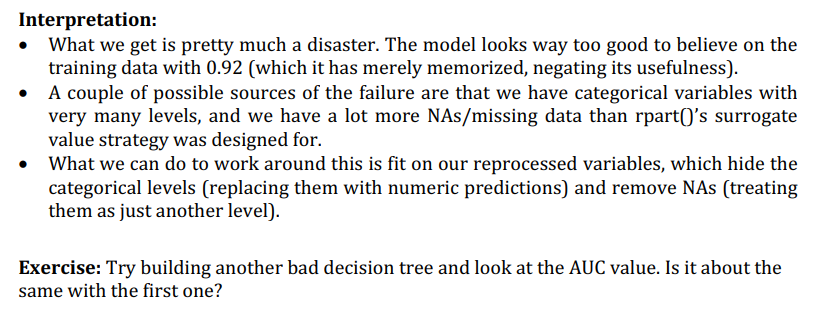

In [52]:
tVars <- paste('pred', c(catVars, numericVars), sep='')
fV2 <- paste(outcome,'>0 ~ ',paste(tVars,collapse=' + '),sep='')
tmodel <- rpart(fV2, data=dTrain)

In [53]:
print(calcAUC(predict(tmodel, newdata=dTrain), dTrain[,outcome]))

[1] 0.928669


In [54]:
print(calcAUC(predict(tmodel, newdata=dTest), dTest[,outcome]))

[1] 0.5390648


In [55]:
print(calcAUC(predict(tmodel, newdata=dCal), dCal[,outcome]))

[1] 0.5384152


> It is more or less the same with the result obtained in the example, the model perform worse on `dTest` and `dCal` data than on the `dTrain` data